In [1]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras import optimizers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
from librosa import display
from librosa.output import write_wav
import IPython.display as ipd

Using TensorFlow backend.


In [2]:
sr = 16000
power = .5
shape = (128, 24)

In [3]:
import os
from tqdm import tqdm
power = .5

# turn raw audio into spectrograms and save that data as an npy file to load again later
def prep_data():
    spectrograms = []
    folders = os.listdir('./data/speech_clips/')
    for folder in tqdm(folders):
        files = os.listdir('./data/speech_clips/' + folder +'/')
        for file in files:
            data, rate = librosa.load('./data/speech_clips/' + folder + '/' + file, duration=1, sr=sr)
            spectrogram = librosa.feature.melspectrogram(y=data, sr=rate, n_mels=128, power=power)
            if spectrogram.shape[1] == 24:
                spectrograms.append(spectrogram)
            
    X_train = np.array(spectrograms)
    
    np.save('./data/speech_data', X_train)
    return X_train.shape

#prep_data()

In [4]:
X_train = np.load('./data/speech_data.npy')
_max = np.amax(X_train)

# normalize
X_train = X_train / _max

# save a few samples for testing data
X_test = X_train[:3]
X_train = X_train[3:]
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [5]:
def denormalize(array):
    return array * _max

In [6]:
# add noise to the input
noise_factor = 0.1
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.5, scale=.2, size=X_train.shape) 
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.5, scale=.2, size=X_test.shape) 
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [7]:
# define model
autoencoder = Sequential()

autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(128, 24, 1)))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))

autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

optim = Adam(lr=.002)
autoencoder.compile(optimizer=optim, loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# input is the noisy data 
# target output is the original data
autoencoder.fit(X_train_noisy, X_train, epochs=5, batch_size=64, validation_split=.1, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 26328 samples, validate on 2926 samples
Epoch 1/5
 - 547s - loss: 0.1140 - val_loss: 0.0957
Epoch 2/5
 - 543s - loss: 0.1018 - val_loss: 0.0956
Epoch 3/5
 - 549s - loss: 0.1017 - val_loss: 0.0955
Epoch 4/5
 - 545s - loss: 0.1016 - val_loss: 0.0955
Epoch 5/5
 - 541s - loss: 0.1016 - val_loss: 0.0955


Text(0.5, 1.0, 'Denoised Spectrogram')

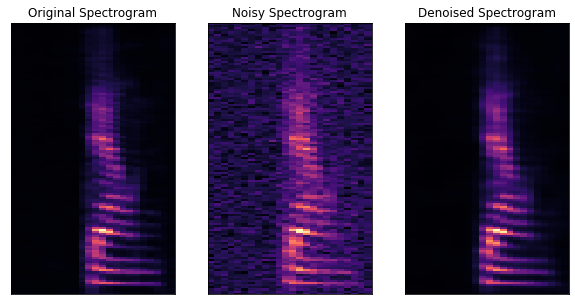

In [9]:
# plot results 
original_spec = X_test[0]
noisy_spec = X_test_noisy[0]
noisy_spec = np.expand_dims(noisy_spec, axis=0)
denoised = autoencoder.predict(noisy_spec) .reshape(128, 24)
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
librosa.display.specshow(original_spec.reshape(128, 24))
plt.title('Original Spectrogram')

plt.subplot(1, 3, 2)
librosa.display.specshow(noisy_spec.reshape(128, 24))
plt.title('Noisy Spectrogram')

plt.subplot(1, 3, 3)

librosa.display.specshow(denoised)
plt.title('Denoised Spectrogram')

In [10]:
original_audio = librosa.feature.inverse.mel_to_audio(denormalize(original_spec.reshape(128, 24)), sr=sr, power=power)
ipd.Audio(original_audio, rate=sr)

In [11]:
noisy_audio = librosa.feature.inverse.mel_to_audio(denormalize(noisy_spec.reshape(128, 24)), sr=sr, power=power)
ipd.Audio(noisy_audio, rate=sr)

In [12]:
denoised_audio = librosa.feature.inverse.mel_to_audio(denormalize(denoised), sr=sr, power=power)
ipd.Audio(denoised_audio, rate=sr)